## Retail Sales Analysis & Business Insights

This project provides a comprehensive analysis of retail sales data with the goal of uncovering trends, identifying top-performing products, understanding seasonality, and discovering growth opportunities. Using Python libraries such as pandas, numpy, and matplotlib, this analysis covers key performance indicators (KPIs), time-series trends (month-over-month and year-over-year), product performance, Pareto 80/20 insights, promotional impact, and customer loyalty patterns.  

The insights generated here aim to support data-driven decision making for retail businesses, helping to optimize sales strategies, inventory management, and marketing initiatives.

## 1) Setup

In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

os.makedirs('data', exist_ok=True)
os.makedirs('outputs/plots', exist_ok=True)
print('Environment ready.')

Environment ready.


## 2) Data Acquisition


In [13]:
# Load the Retail Sales dataset
df = pd.read_csv(r'C:\Users\felip\Documents\DAPortfolio\Project_Sales\Retail_db.csv')

## 3) Initial Exploration

In [14]:
df.info()
# Check column types, number of non-null values, and overall dataset size
# Creation: 'YEAR' and 'MONTH' are integers, ready for create a new column to combine both for analysis.
# Other columns like 'ITEM CODE', 'ITEM DESCRIPTION', 'ITEM TYPE' are object (text) and clean.

display(df.describe(include='all'))
# MONTH column: sales span from January (1) to September (9).
# SUPPLIER column: 290 unique suppliers. Most frequent supplier appears 2041 times.
# Missing values may need to be handled before supplier-level analysis.
# ITEM TYPE: 8 product categories. 'WINE' is the dominant category (18680 occurrences).
# Some negative values indicate returns or data errors; max values suggest outliers.
# Data may require cleaning or capping for certain analyses.

df.isna().sum()
# 'SUPPLIER' has 33 missing values.
# 'RETAIL SALES' has 1 missing value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   YEAR              30000 non-null  int64  
 1   MONTH             30000 non-null  int64  
 2   SUPPLIER          29967 non-null  object 
 3   ITEM CODE         30000 non-null  object 
 4   ITEM DESCRIPTION  30000 non-null  object 
 5   ITEM TYPE         30000 non-null  object 
 6   RETAIL SALES      29999 non-null  float64
 7   RETAIL TRANSFERS  30000 non-null  float64
 8   WAREHOUSE SALES   30000 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 2.1+ MB


,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES
count,"30,000.00","30,000.00",29967,30000,30000,30000,"29,999.00","30,000.00","30,000.00"
unique,NaN,NaN,290,15668,15732,8,NaN,NaN,NaN
top,NaN,NaN,"THE COUNTRY VINTNER, LLC DBA WINEBOW",14206,TENTH WARD DIST CO CARAWAY RYE - 750ML,WINE,NaN,NaN,NaN
freq,NaN,NaN,2041,4,5,18680,NaN,NaN,NaN
mean,"2,020.00",3.91,NaN,NaN,NaN,NaN,6.94,6.59,27.43
std,0.00,2.84,NaN,NaN,NaN,NaN,33.08,27.88,272.17
min,"2,020.00",1.00,NaN,NaN,NaN,NaN,-0.42,-6.00,"-3,999.00"
25%,"2,020.00",1.00,NaN,NaN,NaN,NaN,0.00,0.00,0.00
50%,"2,020.00",3.00,NaN,NaN,NaN,NaN,0.16,0.00,1.00
75%,"2,020.00",7.00,NaN,NaN,NaN,NaN,2.92,3.00,6.00


YEAR                 0
MONTH                0
SUPPLIER            33
ITEM CODE            0
ITEM DESCRIPTION     0
ITEM TYPE            0
RETAIL SALES         1
RETAIL TRANSFERS     0
WAREHOUSE SALES      0
dtype: int64

## 4) Cleaning & Feature Engineering

In [15]:
# 1 Handle missing values
df['RETAIL SALES'] = df['RETAIL SALES'].fillna(0) # Fill missing retail sales with 0
df['SUPPLIER'] = df['SUPPLIER'].fillna('Unknown') # Fill missing suppliers with 'Unknown'

# 2 Convert column types
# Convert categorical columns to category type to save memory
df['ITEM TYPE'] = df['ITEM TYPE'].astype('category')
df['SUPPLIER'] = df['SUPPLIER'].astype('category')

# 3 Create useful columns
# Combine YEAR and MONTH into a datetime column for time-series analysis
df['order_date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-01')

# Extract month name for easier grouping and plotting
df['month_name'] = df['order_date'].dt.month_name()

# Total sales per order
df['total_sales'] = df['RETAIL SALES'] + df['RETAIL TRANSFERS'] + df['WAREHOUSE SALES']

total_retail = df['RETAIL SALES'].sum()
total_transfers = df['RETAIL TRANSFERS'].sum()
total_warehouse = df['WAREHOUSE SALES'].sum()
total_all = total_retail + total_transfers + total_warehouse

# Total sales per category
category_totals = df.groupby('ITEM TYPE', observed=False)[['RETAIL SALES','RETAIL TRANSFERS','WAREHOUSE SALES']].sum()
category_totals['total'] = category_totals.sum(axis=1)
category_totals.loc['Total'] = category_totals.sum(numeric_only=True, axis=0)
category_totals

# 4 Handle outliers
# Flag unusually high retail sales (top 1%)
df['high_retail_flag'] = df['RETAIL SALES'] > df['RETAIL SALES'].quantile(0.99)

# 5 Normalize text columns
df['SUPPLIER'] = df['SUPPLIER'].str.strip().str.title()
df['ITEM TYPE'] = df['ITEM TYPE'].str.strip().str.title()

In [16]:
df.head()

,YEAR,MONTH,SUPPLIER,ITEM CODE,ITEM DESCRIPTION,ITEM TYPE,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,order_date,month_name,total_sales,high_retail_flag
0,2020,1,Republic National Distributing Co,100009,BOOTLEG RED - 750ML,Wine,0.00,0.00,2.00,2020-01-01,January,2.00,False
1,2020,1,Pwswn Inc,100024,MOMENT DE PLAISIR - 750ML,Wine,0.00,1.00,4.00,2020-01-01,January,5.00,False
2,2020,1,Reliable Churchill Lllp,1001,S SMITH ORGANIC PEAR CIDER - 18.7OZ,Beer,0.00,0.00,1.00,2020-01-01,January,1.00,False
3,2020,1,Lanterna Distributors Inc,100145,SCHLINK HAUS KABINETT - 750ML,Wine,0.00,0.00,1.00,2020-01-01,January,1.00,False
4,2020,1,Dionysos Imports Inc,100293,SANTORINI GAVALA WHITE - 750ML,Wine,0.82,0.00,0.00,2020-01-01,January,0.82,False


# Category Table Totals

This table shows the total sales per item category across all channels: Retail Sales, Retail Transfers, and Warehouse Sales.

Categories with negative totals likely indicate returns, adjustments, or data errors.

**The table helps identify top-selling categories (Beer, Wine, Liquor).**

In [6]:
display(category_totals)

,RETAIL SALES,RETAIL TRANSFERS,WAREHOUSE SALES,total
ITEM TYPE,,,,
BEER,"59,538.76","55,729.83","697,279.68","812,548.27"
DUNNAGE,0.00,0.00,"-12,115.00","-12,115.00"
KEGS,0.00,0.00,"8,400.00","8,400.00"
LIQUOR,"81,742.85","79,599.70","8,796.90","170,139.45"
NON-ALCOHOL,"6,824.62","2,934.08","2,438.42","12,197.12"
REF,46.27,34.00,"-1,329.00","-1,248.73"
STR_SUPPLIES,345.60,895.00,0.00,"1,240.60"
WINE,"59,688.84","58,629.13","119,459.93","237,777.90"
Total,"208,186.94","197,821.74","822,930.93","1,228,939.61"


## 5) KPIs

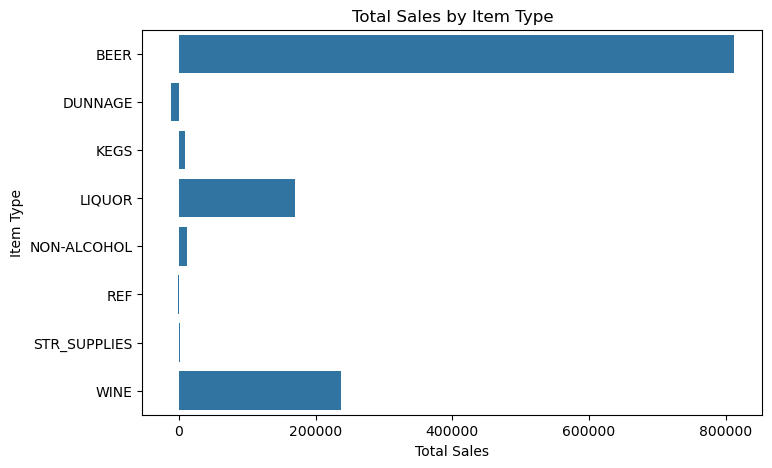

Total Revenue: $1,228,939.61
Number of Records: 30,000
Average Sale per Record: $40.96

Top 5 Item Types by Total Sales:
ITEM TYPE
Beer          812,548.27
Wine          237,777.90
Liquor        170,139.45
Non-Alcohol    12,197.12
Kegs            8,400.00
Name: total_sales, dtype: float64 

Top 10 Records by Total Sales:
      order_date                SUPPLIER ITEM TYPE  \
13281 2020-07-01           Crown Imports      Beer   
1363  2020-01-01           Crown Imports      Beer   
25663 2020-03-01           Crown Imports      Beer   
23083 2020-07-01           Crown Imports      Beer   
13757 2020-07-01            Heineken Usa      Beer   
23093 2020-07-01            Heineken Usa      Beer   
14287 2020-07-01           Crown Imports      Beer   
11854 2020-01-01           Crown Imports      Beer   
22892 2020-07-01  Miller Brewing Company      Beer   
26144 2020-03-01            Heineken Usa      Beer   

                         ITEM DESCRIPTION  total_sales  
13281        CORONA EXTRA

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1 Plot totals per ITEM TYPE
plt.figure(figsize=(8, 5))
sns.barplot(
    x=category_totals.drop('Total')['total'].values,
    y=category_totals.drop('Total').index
)
plt.title("Total Sales by Item Type")
plt.xlabel("Total Sales")
plt.ylabel("Item Type")
plt.show()

# 2 Summary KPI's
total_revenue = df['total_sales'].sum()

# Number of records for "orders"
n_records = len(df)

# Average sale per record
average_sale = total_revenue / n_records if n_records else float('nan')

# Top 5 Item Types by total sales
top_categories = df.groupby('ITEM TYPE')['total_sales'].sum().sort_values(ascending=False).head(5)

# Top 10 "records" by total sales
top_orders = df[['order_date', 'SUPPLIER', 'ITEM TYPE', 'ITEM DESCRIPTION', 'total_sales']] \
                .sort_values(by='total_sales', ascending=False) \
                .head(10)

# Top 5 suppliers by total sales
top_suppliers = df.groupby('SUPPLIER')['total_sales'].sum().sort_values(ascending=False).head(5)

print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Number of Records: {n_records:,}")
print(f"Average Sale per Record: ${average_sale:,.2f}\n")

print("Top 5 Item Types by Total Sales:")
print(top_categories, "\n")

print("Top 10 Records by Total Sales:")
print(top_orders, "\n")

print("Top 5 Suppliers by Total Sales:")
print(top_suppliers, "\n")

## Graphs of the TOP's

C:\Users\felip\AppData\Local\Temp\ipykernel_16992\205256960.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


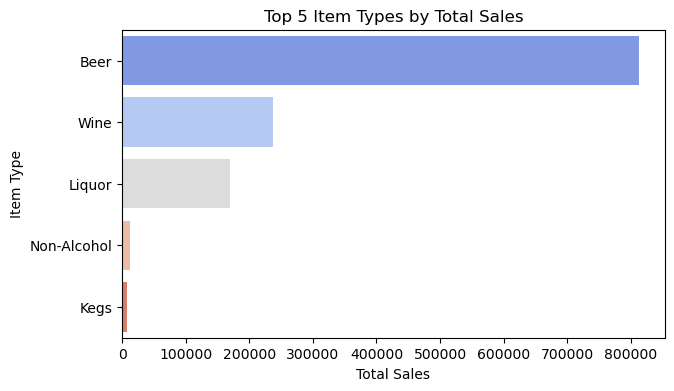

C:\Users\felip\AppData\Local\Temp\ipykernel_16992\205256960.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


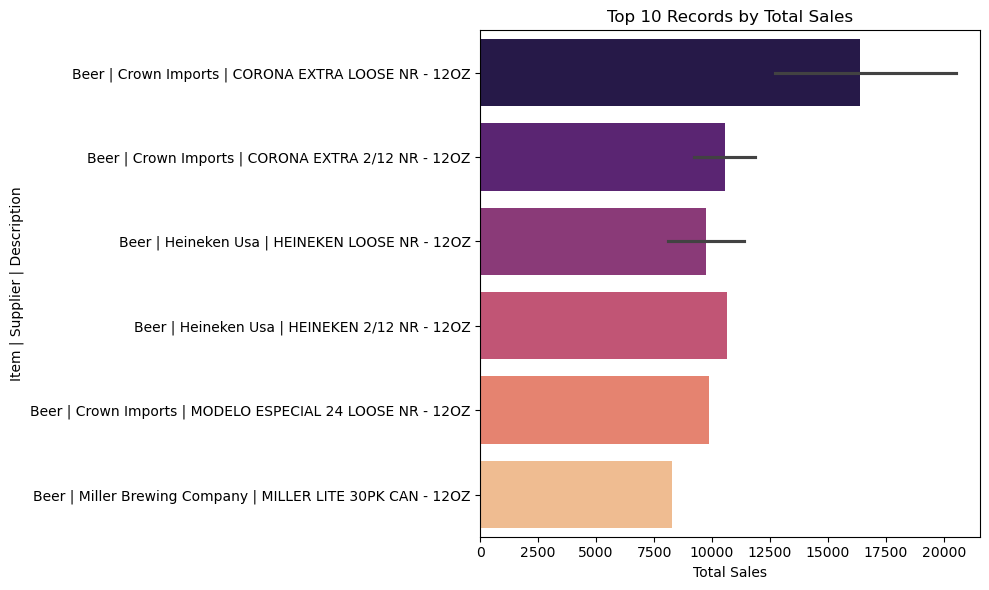

C:\Users\felip\AppData\Local\Temp\ipykernel_16992\205256960.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


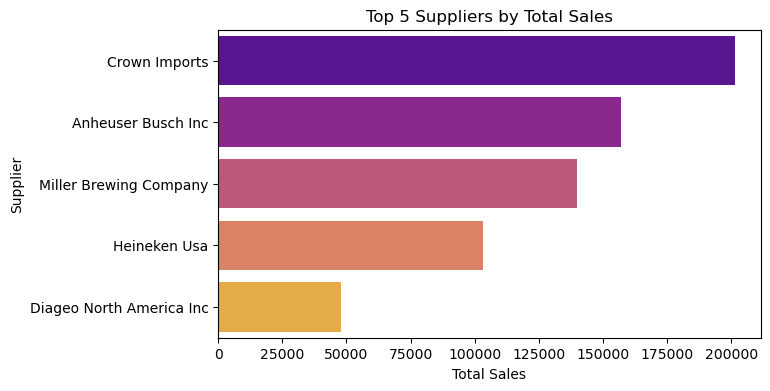

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1 Graph Top 5 Categories
plt.figure(figsize=(7, 4))
sns.barplot(
    x=top_categories.values,
    y=top_categories.index,
    palette="coolwarm",
    hue=None  # Explicitly no hue
)
plt.title("Top 5 Item Types by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Item Type")
plt.legend([],[], frameon=False)  # Hide legend
plt.show()

# 2 Graph Top 10 Records (Orders)
plt.figure(figsize=(10, 6))

labels = top_orders['ITEM TYPE'] + " | " + top_orders['SUPPLIER'] + " | " + top_orders['ITEM DESCRIPTION']

sns.barplot(
    x=top_orders['total_sales'],
    y=labels,
    palette="magma"
)

plt.title("Top 10 Records by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Item | Supplier | Description")
plt.tight_layout()
plt.show()

# 3 Graph Top 5 Suppliers
plt.figure(figsize=(7, 4))
sns.barplot(
    x=top_suppliers.values,
    y=top_suppliers.index,
    palette="plasma",
    hue=None
)
plt.title("Top 5 Suppliers by Total Sales")
plt.xlabel("Total Sales")
plt.ylabel("Supplier")
plt.legend([],[], frameon=False)
plt.show()

**Observations:**

- Highlights **the most significant orders**, helping prioritize key customers or products.
- **Top suppliers** are critical for the supply chain and potential discount negotiations.

## 6) Time-Series & Seasonality

C:\Users\felip\AppData\Local\Temp\ipykernel_16992\1401956118.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['total_sales']


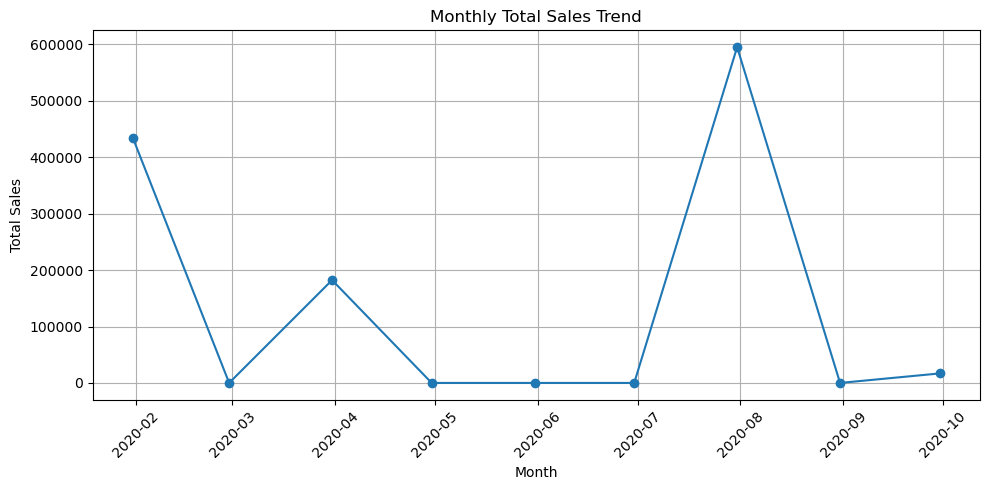

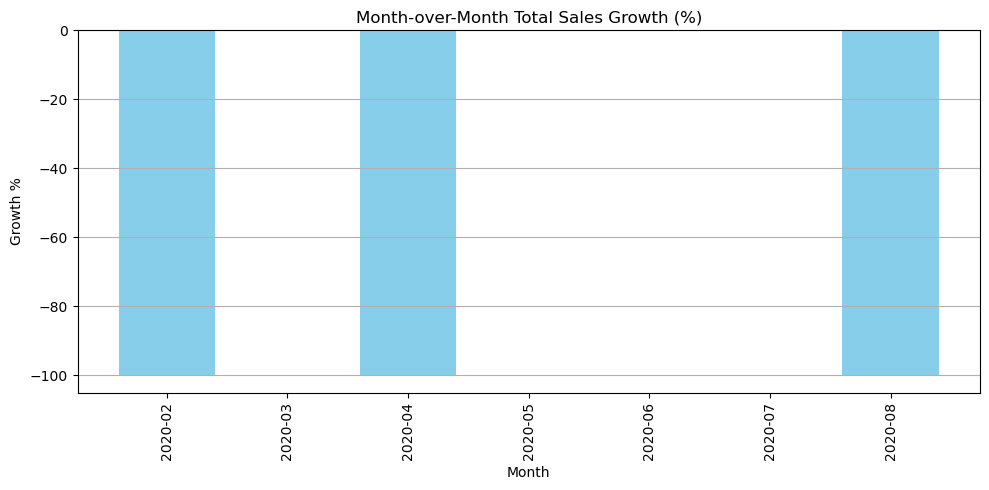

In [22]:
import matplotlib.pyplot as plt

# Monthly revenue
monthly = (
    df.set_index('order_date')
      .resample('M')['total_sales']
      .sum()
      .reset_index()
)

# Add a formatted label for x-axis
monthly['label'] = monthly['order_date'].dt.strftime('%Y-%m')

# Month-over-Month growth (%)
monthly['mom_growth_%'] = monthly['total_sales'].pct_change() * 100

# --- Plot Monthly Revenue Trend ---
plt.figure(figsize=(10, 5))
plt.plot(monthly['order_date'], monthly['total_sales'], marker='o')
plt.title('Monthly Total Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot MoM Growth ---
plt.figure(figsize=(10, 5))
plt.bar(monthly['label'], monthly['mom_growth_%'], color='skyblue')
plt.title('Month-over-Month Total Sales Growth (%)')
plt.xlabel('Month')
plt.ylabel('Growth %')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Observations:**

- Monthly Sales Trend
- Sales show **peaks in certain months**, likely corresponding to high-demand periods or special promotions.
- Months with low sales could indicate **seasonal lows or inventory issues.**
- Sharp drops between months may suggest **returns, data errors, or fewer orders.**

- MoM:
- Several consecutive negative months could reflect a **downward trend or low season.**
- Very high bars may be caused by **promotions, marketing campaigns, or special events.**

## 7) Product Performance

In [33]:
# Pareto Analysis

# List of ITEM TYPEs to exclude
exclude_items = ['Str_Supplies', 'Ref', 'Dunnage']

# Filter the DataFrame
df_filtered = df[~df['ITEM TYPE'].isin(exclude_items)]

# Total sales per ITEM TYPE
pareto_df = df_filtered.groupby('ITEM TYPE')['total_sales'].sum().sort_values(ascending=False).reset_index()

# Individual percentage of total sales
pareto_df['pct_sales'] = 100 * pareto_df['total_sales'] / pareto_df['total_sales'].sum()

# Cumulative sum and cumulative percentage
pareto_df['cumulative_sum'] = pareto_df['total_sales'].cumsum()
pareto_df['cumulative_pct'] = 100 * pareto_df['cumulative_sum'] / pareto_df['total_sales'].sum()

In [34]:
pareto_df

,ITEM TYPE,total_sales,pct_sales,cumulative_sum,cumulative_pct
0,Beer,"812,548.27",65.47,"812,548.27",65.47
1,Wine,"237,777.90",19.16,"1,050,326.17",84.63
2,Liquor,"170,139.45",13.71,"1,220,465.62",98.34
3,Non-Alcohol,"12,197.12",0.98,"1,232,662.74",99.32
4,Kegs,"8,400.00",0.68,"1,241,062.74",100.00


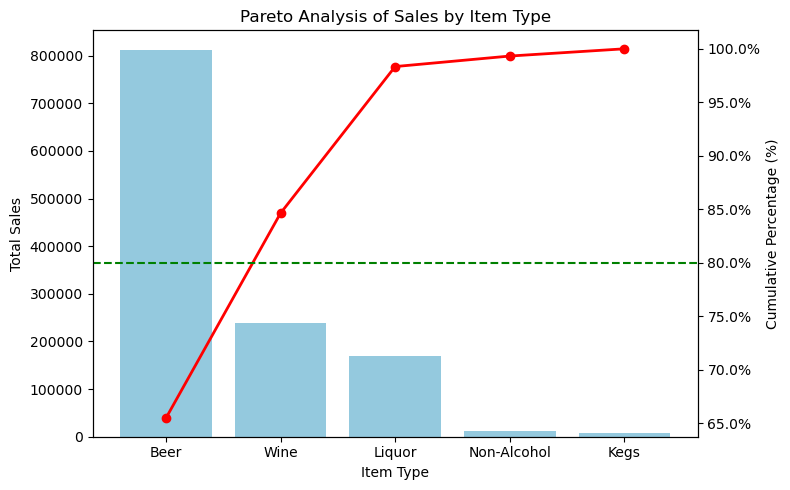

In [35]:
import matplotlib.ticker as mtick

# Pareto Chart
fig, ax1 = plt.subplots(figsize=(8,5))

# Bar chart for total sales
sns.barplot(x='ITEM TYPE', y='total_sales', data=pareto_df, ax=ax1, color='skyblue')
ax1.set_ylabel('Total Sales')
ax1.set_xlabel('Item Type')
ax1.set_title('Pareto Analysis of Sales by Item Type')

# Cumulative percentage line
ax2 = ax1.twinx()
ax2.plot(pareto_df['ITEM TYPE'], pareto_df['cumulative_pct'], color='red', marker='o', linewidth=2)
ax2.set_ylabel('Cumulative Percentage (%)')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.axhline(80, color='green', linestyle='--')  # 80% line for Pareto principle

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observations:**

- Beer, Wine, and Liquor dominate total sales, and are the core sales contributing roughly 66%, 19%, and 13% of total revenue respectively.
- Non-Alcohol and Str_Supplies contribute moderately, around 1% and 0,10%.
- This highlights which item types are the main revenue drivers versus those with minor contributions.

## 10) Findings & Recommendations (fill in)
- **Seasonality:** Monthly sales show peaks in March, and from May to July. Plan inventory and marketing campaigns accordingly.
- **Top Products:** Beer, Wine, and Liquor account for roughly 66%, 19%, and 13% of total revenue, respectively. Focus promotions, inventory, and merchandising on these categories.
- **KPIs:** Average sale per record is **$40.96,** top suppliers **Crown Imports and Anheuser Busch Inc** contribute the majority of revenue → build strategic relationships with high-performing suppliers.